In [1]:
import torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torch import nn

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3., 2., 2., 1., 1.])


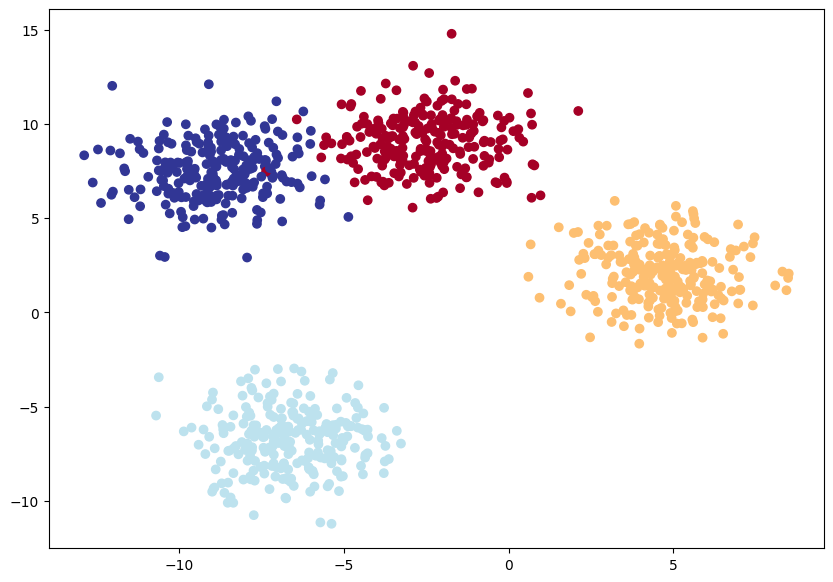

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features= NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state= RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.float32)

print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features= input_features, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Linear(in_features= hidden_units, out_features= output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1) 

In [6]:
model(X_blob_train.to(device))[:5]

tensor([[ 0.8533,  0.2830,  0.0296, -0.0552],
        [-1.0736,  1.2169, -1.0803, -1.5530],
        [-0.1966, -1.2909, -0.1388,  0.0398],
        [-0.2386, -0.6793, -0.2869, -0.2515],
        [-0.9614,  0.9049, -0.9617, -1.3530]], grad_fn=<SliceBackward0>)

In [7]:
model(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [8]:
y_logits = model(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 6.7081e-01,  4.4967e-01, -9.1876e-02, -2.3126e-01],
        [-1.7162e+00,  9.0373e-01, -1.3196e+00, -1.7792e+00],
        [ 6.3956e-02, -1.1493e+00, -4.4844e-02,  1.2515e-01],
        [ 8.3871e-01,  1.7524e-03,  8.1625e-02,  5.9585e-02],
        [-7.1738e-01,  1.2810e+00, -9.2472e-01, -1.3796e+00]],
       grad_fn=<SliceBackward0>)
tensor([[0.3740, 0.2998, 0.1744, 0.1517],
        [0.0583, 0.8004, 0.0866, 0.0547],
        [0.3070, 0.0912, 0.2754, 0.3264],
        [0.4236, 0.1834, 0.1987, 0.1943],
        [0.1030, 0.7601, 0.0837, 0.0531]], grad_fn=<SliceBackward0>)


In [9]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [10]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3740, 0.2998, 0.1744, 0.1517], grad_fn=<SelectBackward0>)
tensor(0)


In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [13]:
y_blob_train = y_blob_train.to(device).long()
y_blob_test  = y_blob_test.to(device).long()


In [14]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model.train()


    y_logits = model(X_blob_train) 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 

    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
      test_logits = model(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 2.12082, Acc: 2.38% | Test Loss: 0.92037, Test Acc: 57.50%
Epoch: 10 | Loss: 0.27714, Acc: 88.75% | Test Loss: 0.25068, Test Acc: 91.00%
Epoch: 20 | Loss: 0.10173, Acc: 99.25% | Test Loss: 0.09302, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06898, Acc: 99.38% | Test Loss: 0.06135, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05420, Acc: 99.38% | Test Loss: 0.04663, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04605, Acc: 99.25% | Test Loss: 0.03832, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04098, Acc: 99.25% | Test Loss: 0.03304, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03756, Acc: 99.12% | Test Loss: 0.02942, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03511, Acc: 99.12% | Test Loss: 0.02679, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03329, Acc: 99.12% | Test Loss: 0.02479, Test Acc: 99.50%


In [16]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

y_logits[:10]

tensor([[  7.4312,  12.8342,  -9.9871,  -5.9881],
        [  1.0153, -14.0089,  -0.9648,   6.3388],
        [-10.7588, -15.2563,  14.5094,   6.3230],
        [  3.8647,   9.5624,  -5.2346,  -4.6285],
        [  9.1794,   4.2605, -12.0871,  -1.8561],
        [  0.6965, -17.5180,  -0.4674,   7.9769],
        [-10.1659, -11.4671,  13.6462,   4.5668],
        [  6.8195,  -0.5619,  -8.8824,   0.2965],
        [-12.4379, -21.5504,  16.8542,   9.2044],
        [  7.5471,   1.2036,  -9.8769,  -0.4986]])

In [17]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [22]:
from helper_functions import plot_decision_boundary

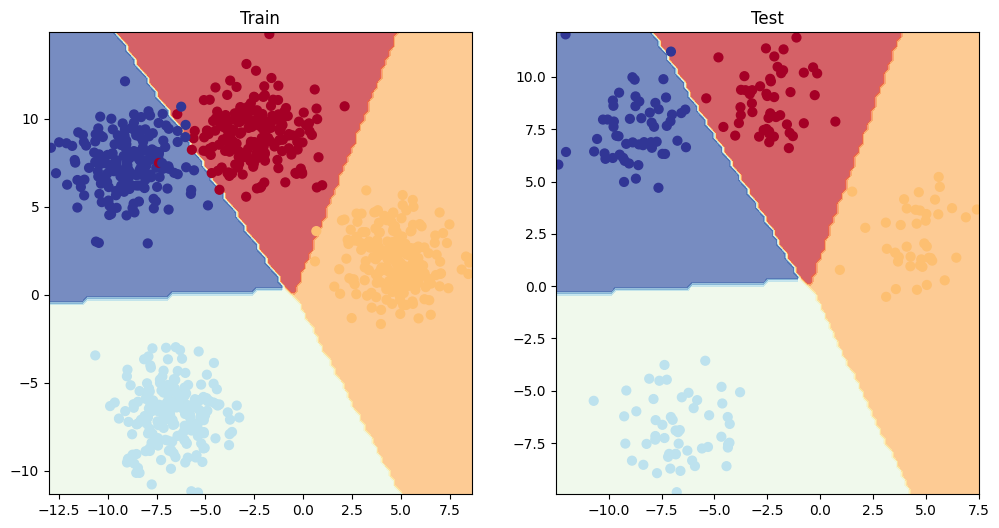

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)